In [1]:
#This code anipulates data files and reads label text files

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import shutil
import librosa
import soundfile as sf
import random
import math

In [56]:
#Reads the data from set of labels
with open('data/vocalizationcorpus/labels.txt', 'r') as f:
    file_lines = f.readlines()

keymap =  pd.DataFrame([string.split(',') for string in file_lines])

In [57]:
#converts dataframe to numpy array
keymap_np = keymap.to_numpy()
keymap_np.shape
#Take a look at the text file to get a feel of the data

(2764, 22)

In [58]:
keymap_np[10,:]#Shows one row of keymap_np

array(['S0010', 'F19-R', 'Female', '465.451', 'laughter', '6.705',
       '7.917\n', None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None], dtype=object)

In [60]:
position = np.argmax(keymap_np[10,:]=='laughter')#Gives index of position where 'laughter' is written. 
#(position + 1) index is for laughter starting time
#(positio + 2) index is for laughter ending time
print(position)

4


In [18]:
Fcounter = 0
Lcounter = 0
for i in range(1,2763):
    if np.argmax(keymap_np[i,:]=='laughter') != 0:
        Lcounter = Lcounter + 1
        if np.argmax(keymap_np[i,:]=='Female') != 0:
            Fcounter = Fcounter +1
            
print('Number of laughter events = ', Lcounter)
print('Number of Female laughter events = ', Fcounter)
print('Number of Male laughter events = ', Lcounter - Fcounter)

Number of laughter events =  935
Number of Female laughter events =  527
Number of Male laughter events =  408


In [17]:
Fcounter

527

# VISUALISING THE DATASET

In [63]:
t_start = []
t_end = []
for i in range(1,2763):
    if np.argmax(keymap_np[i,:]=='laughter') != 0:
        t_start.append(keymap_np[i,np.argmax(keymap_np[i,:]=='laughter')+1])
        t_end.append(keymap_np[i,np.argmax(keymap_np[i,:]=='laughter')+2])

        
t_start = np.array(np.char.strip(t_start,'\n')).astype(np.float)
t_end = np.array(np.char.strip(t_end,'\n')).astype(np.float)

In [64]:
mean = np.mean(t_end - t_start)#mean laughter time
print('Mean = ', mean, 'seconds')

std = np.std(t_end - t_start)#std
print('Standard Deviation = ', std, 'seconds')

Mean =  0.9339978609625669 seconds
Standard Deviation =  0.6981486549299163 seconds


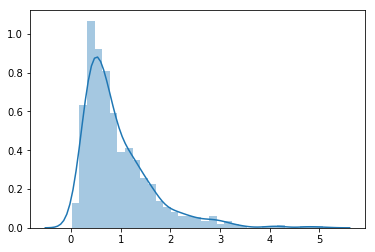

In [65]:
sns.distplot(t_end - t_start); # plots the distribution of laughter times

# SEGMENTING LAUGHTERS 

In [15]:
#SEGMENT LAUGHTER into windows of size 0.5 seconds. The windows overlap with each other to approximately 0.25 ms.

In [66]:
#Enter time in seconds
t_segment = 1
t_overlap = t_segment/2

In [67]:
# t_start = []
counter = 0
for i in range(1,2763):
    if np.argmax(keymap_np[i,:]=='laughter') != 0:
        t_begin = np.array(np.char.strip(keymap_np[i,np.argmax(keymap_np[i,:]=='laughter')+1],'\n')).astype(np.float)
        t_finish = np.array(np.char.strip(keymap_np[i,np.argmax(keymap_np[i,:]=='laughter')+2],'\n')).astype(np.float)
        #sf.write('data/NonLaugh/' + f'{i}' + '.wav', np.concatenate((x[0:int(t_begin*sr)],x[math.ceil(t_finish*sr):int(x.shape[0])]), axis=0), sr)
        
        #Find number of segments
        if t_finish - t_begin >= t_segment:
            if i % 100 == 0:
                print('i =', i, 'Segmenting...')
            audio_path = 'data/vocalizationcorpus/data/S' + f'{i:04}' + '.wav'
            x , sr = librosa.load(audio_path, sr=None)
            n_segments = (((t_finish - t_begin)//t_overlap) - 1)#gives number of segments
            for j in range(int(n_segments)):
                counter = counter + 1
                t1 = t_begin + j*t_overlap
                t2 = t1 + t_segment
                sf.write('data/Segmented_Laugh/' + f'{counter}' + '.wav', x[int(t1*sr):int(t2*sr)], sr)    
        

print('Total Number of Laughter Files = ', counter)
        

Total Number of Laughter Files =  17


# SEGMENTING NON-LAUGHTER AUDIOS

In [72]:
Ntotal = counter# Enter how many non-laughter segments you need

In [73]:
counter = 0
while (counter < Ntotal):
    
    file = random.randint(1,2763)
    if np.argmax(keymap_np[file,:]=='laughter') != 0:
        counter = counter + 1
            
        t_begin = np.array(np.char.strip(keymap_np[file,np.argmax(keymap_np[file,:]=='laughter')+1],'\n')).astype(np.float)
        t_finish = np.array(np.char.strip(keymap_np[file,np.argmax(keymap_np[file,:]=='laughter')+2],'\n')).astype(np.float)
        audio_path = 'data/vocalizationcorpus/data/S' + f'{file:04}' + '.wav'
        x , sr = librosa.load(audio_path, sr=None)
        
        t_1 = int(int(t_begin*sr)-1)
        t_2 = int(int(t_finish*sr)+2)
        t_3 = int(x.shape[0]-1)
        x_nonlaugh = np.concatenate((x[0:t_1], x[t_2:t_3]), axis = 0)
        
        size = x_nonlaugh.shape[0]/sr
        t1 = random.randint(0,int(size-t_segment))
        t2 = t1 + t_segment
    
        sf.write('data/Segmented_NonLaugh/' + f'{counter}' + '.wav', x[int(t1*sr):int(t2*sr)], sr)
        if counter % 10 == 0:
            print('Segmenting counter = ', counter)
            
print('Total Files =', counter )

Segmenting counter =  10
Total Files = 17


# SEGMENTING NON-LAUGHTER AUDIOS with NONLAUGH

In [17]:
t_segment = 0.5

In [19]:
counter = 0
while (counter < 616):
    counter = counter + 1
    
    file = random.randint(1,2763)
    t1 = random.randint(1,6)
    t2 = t1 + t_segment
    
    print('Segmenting counter = ', counter, 'File = ', file )
    
    audio_path = 'data/NonLaugh/' + f'{file}' + '.wav'
    x , sr = librosa.load(audio_path, sr=None)
    sf.write('data/Segmented_NonLaugh/' + f'{counter}' + '.wav', x[int(t1*sr):int(t2*sr)], sr)

Segmenting counter =  1 File =  1185
Segmenting counter =  2 File =  499
Segmenting counter =  3 File =  1258
Segmenting counter =  4 File =  2598
Segmenting counter =  5 File =  1240
Segmenting counter =  6 File =  1636
Segmenting counter =  7 File =  2306
Segmenting counter =  8 File =  1921
Segmenting counter =  9 File =  2582
Segmenting counter =  10 File =  2666
Segmenting counter =  11 File =  2024
Segmenting counter =  12 File =  1719
Segmenting counter =  13 File =  1862
Segmenting counter =  14 File =  985
Segmenting counter =  15 File =  926
Segmenting counter =  16 File =  29
Segmenting counter =  17 File =  336
Segmenting counter =  18 File =  2552
Segmenting counter =  19 File =  744
Segmenting counter =  20 File =  688
Segmenting counter =  21 File =  1885
Segmenting counter =  22 File =  1103
Segmenting counter =  23 File =  2386
Segmenting counter =  24 File =  892
Segmenting counter =  25 File =  259
Segmenting counter =  26 File =  472
Segmenting counter =  27 File = 

Segmenting counter =  256 File =  2467
Segmenting counter =  257 File =  1097
Segmenting counter =  258 File =  1779
Segmenting counter =  259 File =  2047
Segmenting counter =  260 File =  488
Segmenting counter =  261 File =  1039
Segmenting counter =  262 File =  1855
Segmenting counter =  263 File =  36
Segmenting counter =  264 File =  2371
Segmenting counter =  265 File =  1321
Segmenting counter =  266 File =  1022
Segmenting counter =  267 File =  850
Segmenting counter =  268 File =  2441
Segmenting counter =  269 File =  2248
Segmenting counter =  270 File =  1524
Segmenting counter =  271 File =  1616
Segmenting counter =  272 File =  2519
Segmenting counter =  273 File =  2618
Segmenting counter =  274 File =  391
Segmenting counter =  275 File =  1279
Segmenting counter =  276 File =  136
Segmenting counter =  277 File =  1350
Segmenting counter =  278 File =  2035
Segmenting counter =  279 File =  1611
Segmenting counter =  280 File =  2645
Segmenting counter =  281 File 

Segmenting counter =  488 File =  2185
Segmenting counter =  489 File =  449
Segmenting counter =  490 File =  1099
Segmenting counter =  491 File =  1421
Segmenting counter =  492 File =  72
Segmenting counter =  493 File =  1479
Segmenting counter =  494 File =  911
Segmenting counter =  495 File =  574
Segmenting counter =  496 File =  454
Segmenting counter =  497 File =  457
Segmenting counter =  498 File =  641
Segmenting counter =  499 File =  515
Segmenting counter =  500 File =  59
Segmenting counter =  501 File =  2030
Segmenting counter =  502 File =  1349
Segmenting counter =  503 File =  1544
Segmenting counter =  504 File =  1727
Segmenting counter =  505 File =  55
Segmenting counter =  506 File =  2173
Segmenting counter =  507 File =  923
Segmenting counter =  508 File =  2550
Segmenting counter =  509 File =  453
Segmenting counter =  510 File =  1557
Segmenting counter =  511 File =  1484
Segmenting counter =  512 File =  828
Segmenting counter =  513 File =  1049
Se